# Ensemble Model

Ensemble methods are a powerful technique in machine learning that combine multiple base models to produce a stronger, more robust model. Ensemble methods work on the principle of leveraging the diversity of multiple models to improve predictive performance, reduce overfitting, and increase generalization ability. 

In the context of anomaly detection, ensemble methods can be particularly effective due to the challenging nature of anomaly detection tasks, where anomalies are often rare and exhibit complex patterns. By combining the outputs of multiple anomaly detection models, ensemble methods can enhance the detection of anomalies while reducing false positives and false negatives.

## Table of Content

- Import Libraries
- import Functions
- Load Data
- Load Models
- Predict Individual Anomaly Detection Models
- Ensemble Methods
  - Averaging
    - Metrics
    - Plots
  - Voting
    - Metrics
    - Plots
  - Stacking
    - Metrics
    - Plots
- Analysis and Evaluation

# Import Libraries

In [38]:
from sklearn.linear_model import LogisticRegression
import numpy as np
import sys, os

# Import Functions

In [39]:
sys.path.insert(0, '../../')
from src.functions import Data, Evaluation

dt = Data()
eval = Evaluation()

# Load Data


In [40]:
# Get data directory
data_dir = os.path.join(os.getcwd(), '../../data/processed')

# Load processed data
X_train, X_val, X_test, y_train, y_val, y_test, unlabeled_test = dt.load_data(data_dir)

# Load Models

In [41]:
# Get models directory
models_dir = os.path.join(os.getcwd(), '../trained_models')

# Load models
if_model, lof_model, ocsvm_model = dt.load_ind_models(models_dir)

# Predict Individual Anomaly Detection Models

In [42]:
if_pred = if_model.predict(X_val)
lof_pred = lof_model.predict(X_val)
ocsvm_pred = ocsvm_model.predict(X_val)

/home/ndressler/.pyenv/versions/3.10.6/envs/financial_fraud/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


# Convet dataframes to arrays for efficiency

In [43]:
# Save column names
X_val_df = X_val

# Convert pandas dataframes to numpy arrays for memory efficiency
X_train = X_train.values
X_val = X_val.values
y_train = y_train.values
y_val = y_val.values

# Ensemble Models

## Averaging Ensemble

This is a simple method where we average the prediction probabilities of the individual models. It's straightforward to implement and can often give good results if our models are roughly equally good.

In [7]:
# Aggregate predictions
avg_pred_val = np.vstack((if_pred, lof_pred, ocsvm_pred)).mean(axis=0)

# Define threshold for considering an instance as anomaly
avg_threshold = 0

# Convert predictions to binary labels (anomaly or normal)
avg_pred_val_binary = np.where(avg_pred_val > avg_threshold, 1, -1)

### Metrics

In [10]:
# Get Confusion Matrix information
avg_cm = eval.get_cm(avg_pred_val_binary, y_val)
eval.cm_inf(avg_cm, 'Averaging Ensemble Model')

Confusion Matrix for model Averaging Ensemble Model:

True Positives: 22
True Negatives: 113363
False Positives: 612
False Negatives: 4111




In [11]:
# Print the Classification Report
eval.print_classreport(y_val, avg_pred_val_binary, 'Averaging Ensemble Model')

Classification Report for Averaging Ensemble Model:

              precision    recall  f1-score   support

          -1       0.03      0.01      0.01      4133
           1       0.97      0.99      0.98    113975

    accuracy                           0.96    118108
   macro avg       0.50      0.50      0.49    118108
weighted avg       0.93      0.96      0.95    118108





In [12]:
# Evaluate ensemble performance
avg_metrics = eval.get_metrics(avg_cm, y_val, avg_pred_val_binary)
eval.print_metrics(avg_metrics, 'Averaging Ensemble Model')

Metrics of Averaging Ensemble Model:

Recall: 0.0053
Precision: 0.0347
F1 Score: 0.0092
PR AUC: 0.035
AU ROC: 0.5
Specificity: 0.9946




### Plots

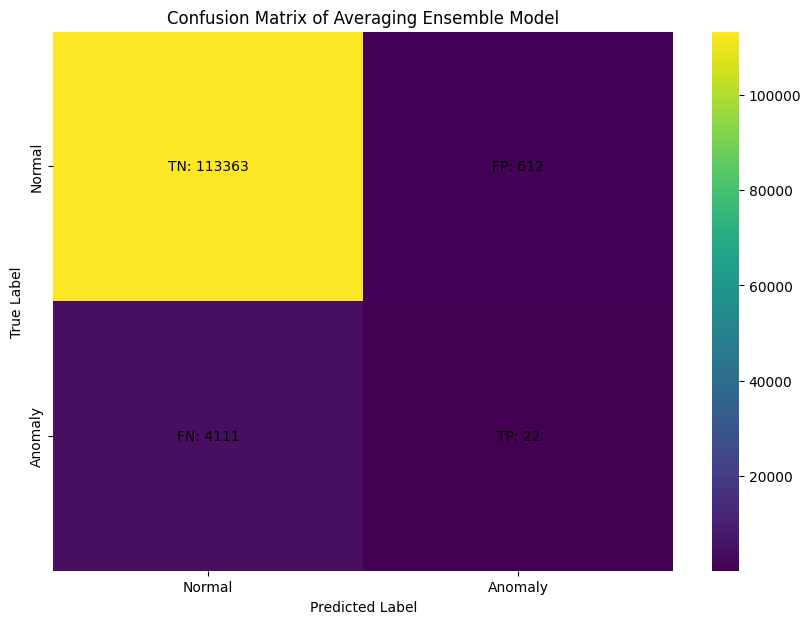

In [13]:
# Plot Confusion Matrix
eval.plot_cm(avg_cm, 'Averaging Ensemble Model')

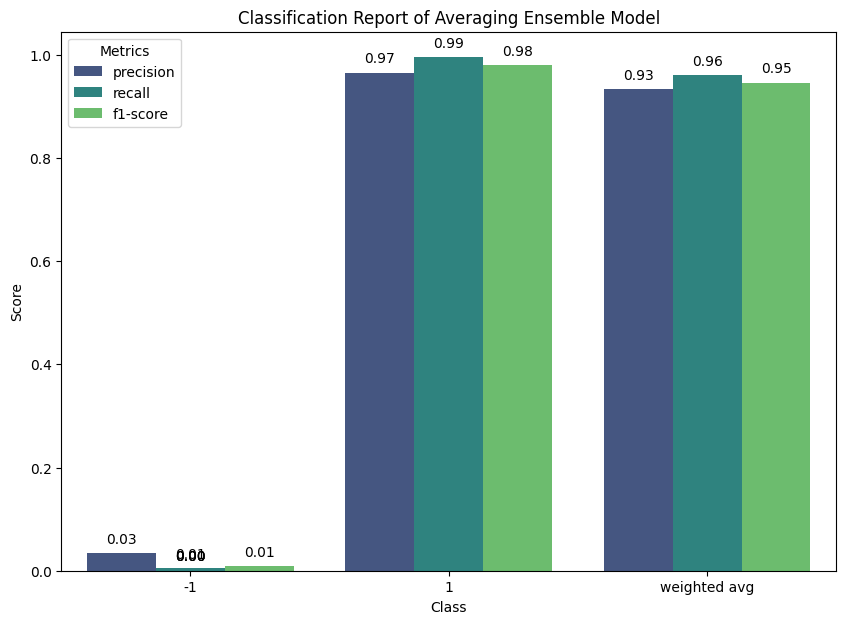

In [14]:
# Plot Classification Report
eval.plot_classreport(y_val, avg_pred_val_binary, 'Averaging Ensemble Model')

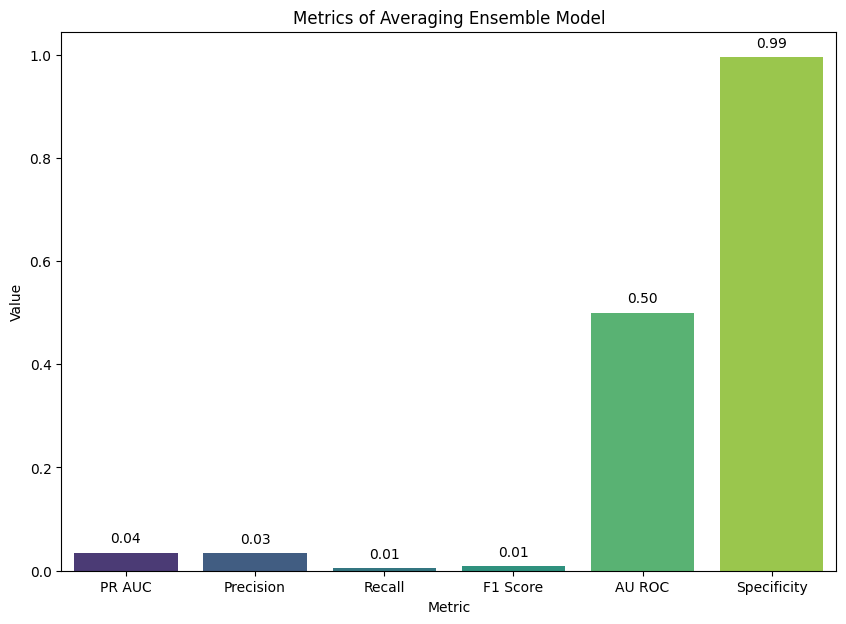

In [15]:
# Plot Metrics
eval.plot_metrics(avg_metrics, 'Averaging Ensemble Model')

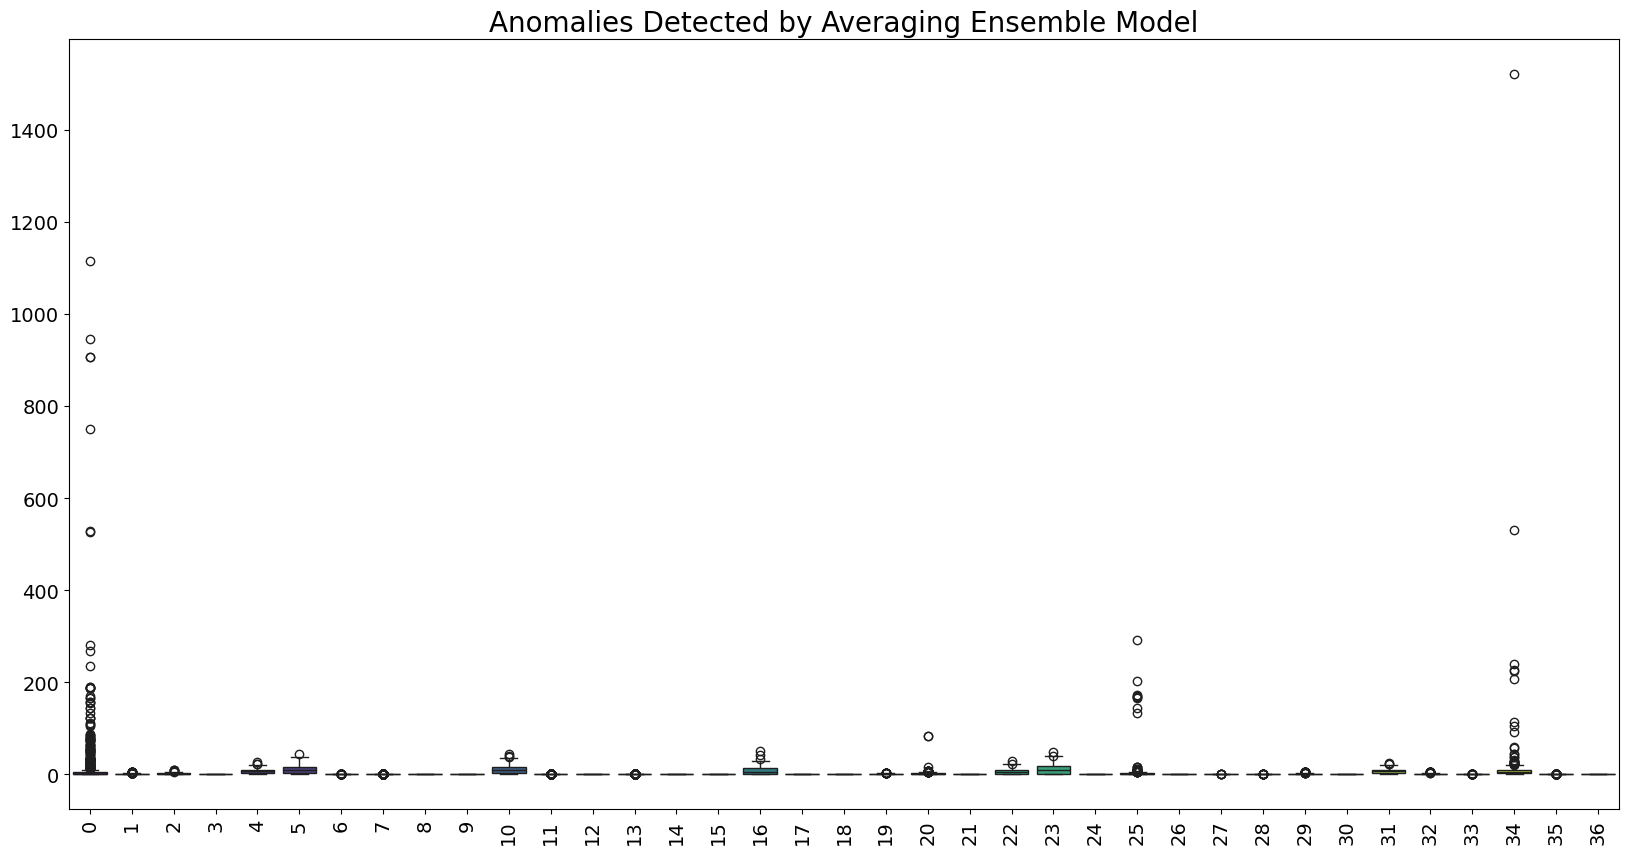

In [16]:
# Plot Anomaly Analysis

# Get Anomalies
avg_anomalies = X_val[np.where(avg_pred_val_binary == -1)]

# Plot Anomalies
eval.plot_anomalies(avg_anomalies, 'Averaging Ensemble Model')

## Voting Ensemble

This method involves each model 'voting' for a class, and the class with the most votes is chosen as the final prediction.

The `VotingClassifier` in scikit-learn is designed for supervised learning models that can output class probabilities, which is not the case for the `LocalOutlierFactor` and `OneClassSVM` models we're using. These models are used as semi-supervised learning tasks, specifically anomaly detection, where the goal is to identify unusual data points that differ significantly from the majority of the data. I'm implementing a simple voting mechanism manually: for each data point, we're counting the number of models that consider it an anomaly, and if a majority of models consider it an anomaly, we're labeling it as an anomaly. This approach allows us to leverage the strengths of multiple models and potentially improve the robustness of your anomaly detection.

In [17]:
# Count the number of models that consider each point an anomaly
votes = np.vstack((if_pred, lof_pred, ocsvm_pred))

# If a majority of models consider a point an anomaly, label it as an anomaly
majority_vote = np.where(votes.sum(axis=0) < 0, -1, 1)

### Metrics

In [18]:
# Get confusion matrix information
vote_cm = eval.get_cm(majority_vote, y_val)
eval.cm_inf(vote_cm, 'Voting Ensemble Model')

Confusion Matrix for model Voting Ensemble Model:

True Positives: 22
True Negatives: 113363
False Positives: 612
False Negatives: 4111




In [19]:
# Print the Classification Report
eval.print_classreport(y_val, majority_vote, 'Voting Ensemble Model')

Classification Report for Voting Ensemble Model:

              precision    recall  f1-score   support

          -1       0.03      0.01      0.01      4133
           1       0.97      0.99      0.98    113975

    accuracy                           0.96    118108
   macro avg       0.50      0.50      0.49    118108
weighted avg       0.93      0.96      0.95    118108





In [20]:
# Evaluate ensemble performance
vote_metrics = eval.get_metrics(vote_cm, y_val, majority_vote)
eval.print_metrics(vote_metrics, 'Voting Ensemble Model')

Metrics of Voting Ensemble Model:

Recall: 0.0053
Precision: 0.0347
F1 Score: 0.0092
PR AUC: 0.035
AU ROC: 0.5
Specificity: 0.9946




### Plots

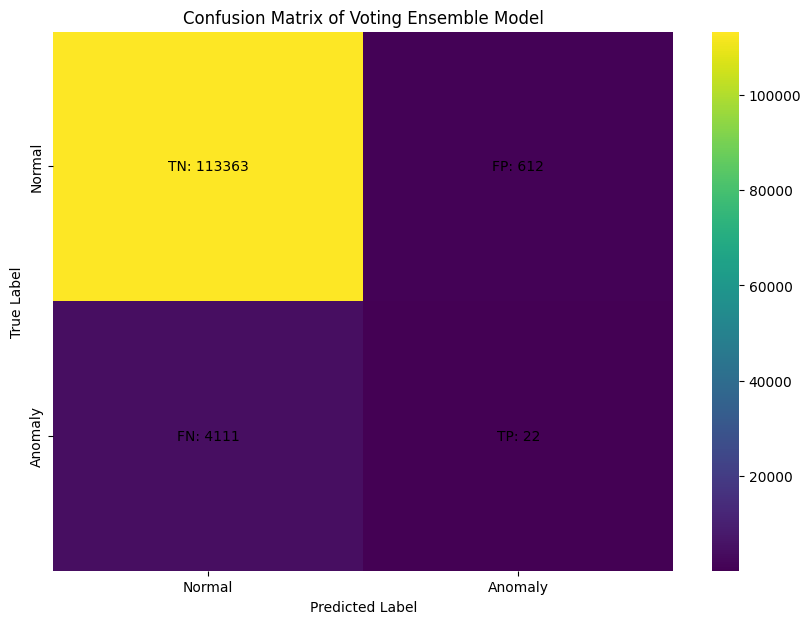

In [21]:
# Plot Confusion Matrix
eval.plot_cm(vote_cm, 'Voting Ensemble Model')

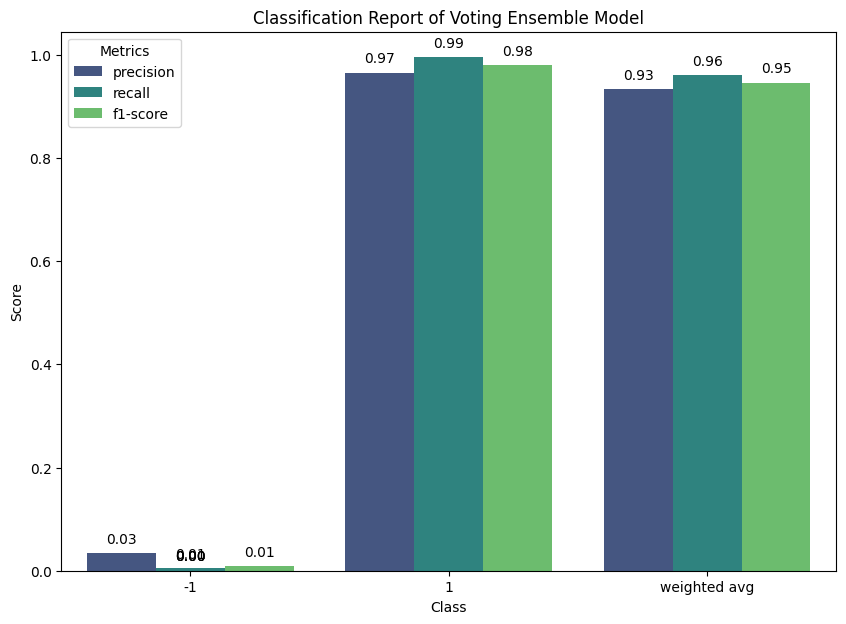

In [22]:
# Plot Classification Report
eval.plot_classreport(y_val, majority_vote, 'Voting Ensemble Model')

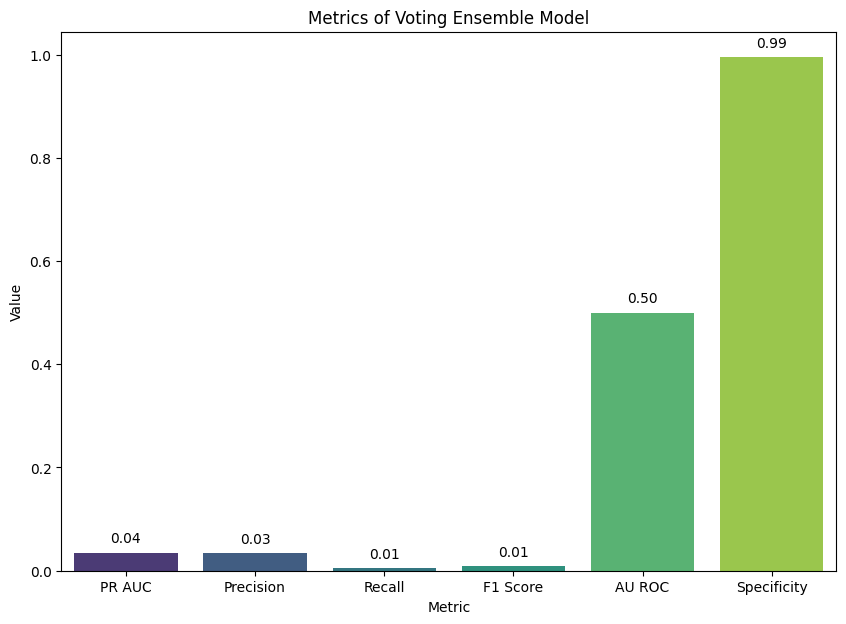

In [23]:
# Plot Metrics
eval.plot_metrics(vote_metrics, 'Voting Ensemble Model')

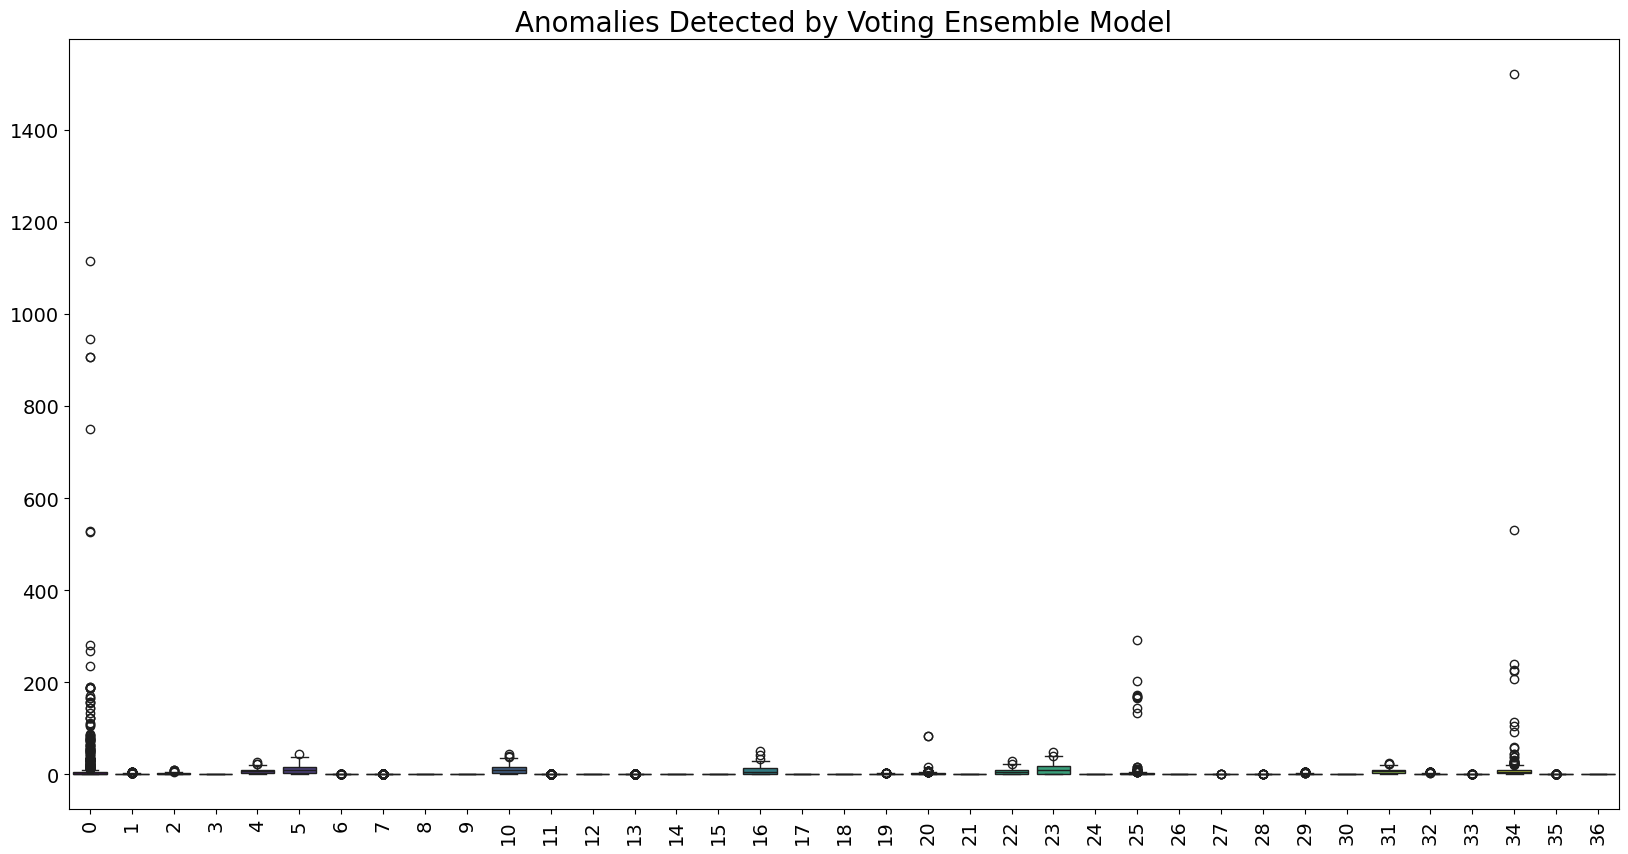

In [24]:
# Plot Anomaly Analysis

# Get Anomalies
vote_anomalies = X_val[np.where(majority_vote == -1)]

# Plot Anomalies
eval.plot_anomalies(vote_anomalies, 'Voting Ensemble Model')

## Stacking Ensemble

In this method, the predictions (or prediction probabilities) of the models are used as input to a new model (the meta-model or second-level model) to make the final prediction. The meta-model is trained to best combine the predictions from the individual models.

Logistic regression is a common choice for a meta-model in stacking ensembles, particularly when the task is binary classification, as it effectively weighs the predictions of the base models to maximize the log-likelihood of the correct labels.

We are using Logistic Regression as the meta-model initially for its simplicity and interpretability.

In [33]:
# Stack predictions
stack_stacked_pred_val = np.vstack((if_pred, lof_pred, ocsvm_pred)).T

# Train meta-model
stack_model = LogisticRegression()
stack_model.fit(stack_stacked_pred_val, y_val.ravel())

# Make predictions with the meta-model
stack_pred_val = stack_model.predict(stack_stacked_pred_val)

### Metrics

In [34]:
# Get confusion matrix information
stack_cm = eval.get_cm(stack_pred_val, y_val)
eval.cm_inf(stack_cm, 'Stacking Ensemble Model')

Confusion Matrix for model Stacking Ensemble Model:

True Positives: 0
True Negatives: 113975
False Positives: 0
False Negatives: 4133




In [35]:
# Print the Classification Report
eval.print_classreport(y_val, stack_pred_val, 'Stacking Ensemble Model')

Classification Report for Stacking Ensemble Model:

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00      4133
           1       0.97      1.00      0.98    113975

    accuracy                           0.97    118108
   macro avg       0.48      0.50      0.49    118108
weighted avg       0.93      0.97      0.95    118108





/home/ndressler/.pyenv/versions/3.10.6/envs/financial_fraud/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ndressler/.pyenv/versions/3.10.6/envs/financial_fraud/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ndressler/.pyenv/versions/3.10.6/envs/financial_fraud/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter t

In [28]:
# Evaluate ensemble performance
stack_metrics = eval.get_metrics(stack_cm, y_val, stack_pred_val)
eval.print_metrics(stack_metrics, 'Stacking Ensemble Model')

Metrics of Stacking Ensemble Model:

Recall: 0.0
Precision: 0.0
F1 Score: 0.0
PR AUC: 0.035
AU ROC: 0.5
Specificity: 1.0




/home/ndressler/.pyenv/versions/3.10.6/envs/financial_fraud/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Plots

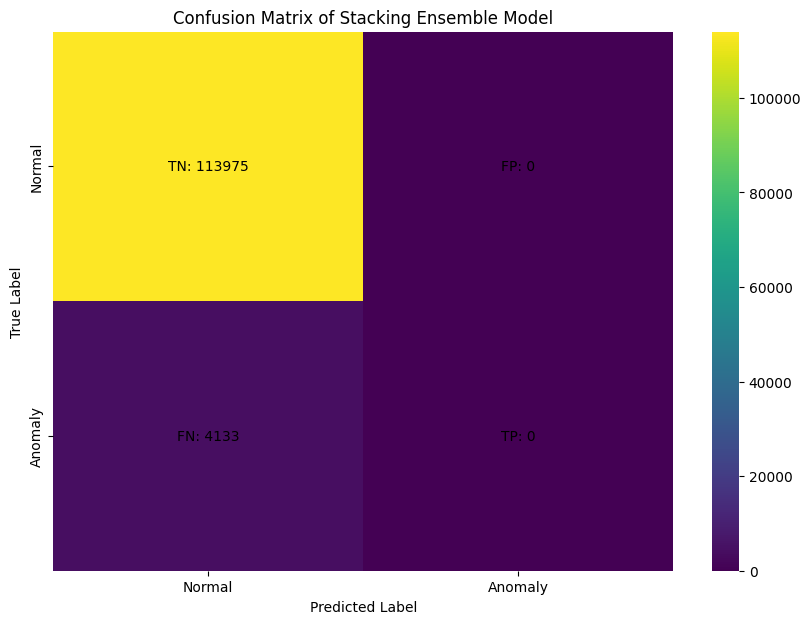

In [29]:
# Plot Confusion Matrix
eval.plot_cm(stack_cm, 'Stacking Ensemble Model')

/home/ndressler/.pyenv/versions/3.10.6/envs/financial_fraud/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ndressler/.pyenv/versions/3.10.6/envs/financial_fraud/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ndressler/.pyenv/versions/3.10.6/envs/financial_fraud/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter t

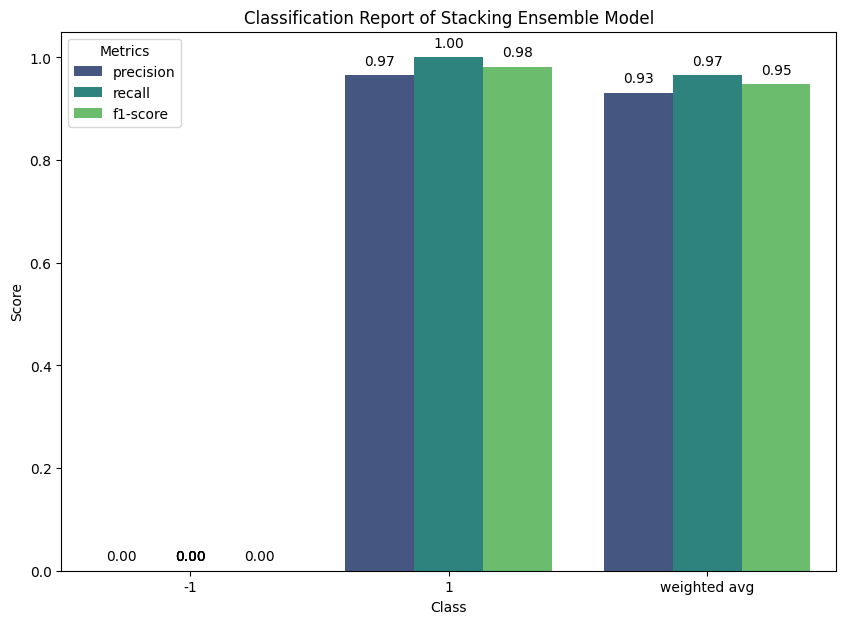

In [30]:
# Plot Classification Report
eval.plot_classreport(y_val, stack_pred_val, 'Stacking Ensemble Model')

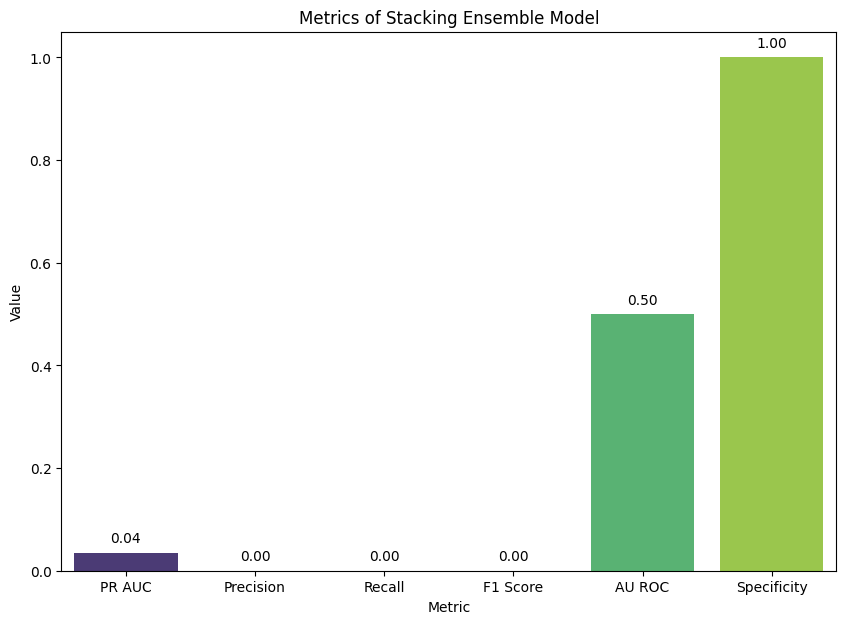

In [31]:
# Plot Metrics
eval.plot_metrics(stack_metrics, 'Stacking Ensemble Model')

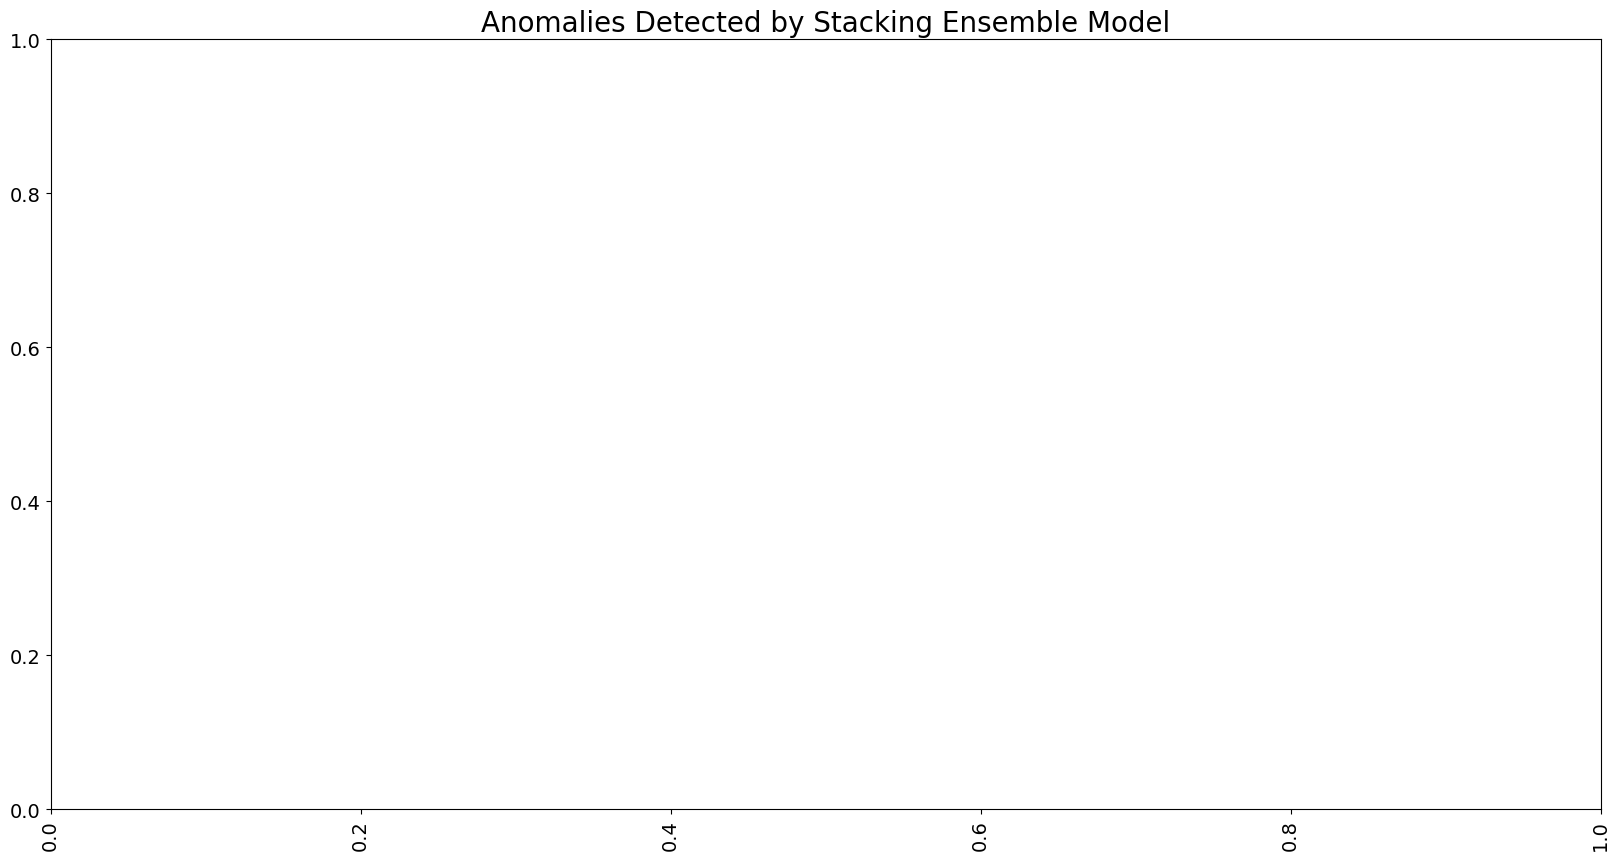

In [32]:
# Plot Anomaly Analysis

# Get Anomalies
stack_anomalies = X_val[np.where(stack_pred_val == -1)]

# Plot Anomalies
eval.plot_anomalies(stack_anomalies, 'Stacking Ensemble Model')

# Analysis and Evaluation

__Averaging and Voting Ensemble Models__

- Recall (Sensitivity): Both methods have the same recall of 0.0053, which indicates an extremely low ability to correctly identify positive cases (fraudulent transactions). This is a significant concern as it suggests that both models miss nearly all fraudulent transactions.
- Precision: Both models have a precision of 0.0347, which is also very low, meaning that a lot of the detected positives are actually false positives.
- F1 Score: With an F1 score of 0.0092, both models show a poor balance between recall and precision.
- AU ROC: The area under the receiver operating characteristic curve is 0.5 for both models, which is no better than random guessing. This indicates poor model performance in distinguishing between the classes.
- Specificity: Very high at 0.9946, showing that these models are good at identifying true negatives but at the cost of missing almost all true positives.

__Stacking Ensemble Model__
- Recall: This model has a recall of 0.0, meaning it fails to identify any true positives at all. It is the worst-performing model in terms of detecting fraudulent transactions.
- Precision: Also 0.0, indicating no fraudulent transactions were correctly identified.
- F1 Score: 0.0, reflecting very poor performance.
- AU ROC: Like the others, it has an AU ROC of 0.5, indicating no discriminative ability.
- Specificity: Perfect specificity (1.0) as it did not mark any negative as positive, but this is due to it failing to mark anything as positive at all.


For this financial fraud detection project, aiming to minimize false negatives and ensure explainability, the voting ensemble method would be the optimal choice. This method not only aligns with the objective of maintaining robustness against varied fraudulent patterns by leveraging the collective wisdom of multiple models but also enhances interpretability, crucial for compliance and operational adjustments.